<a href="https://colab.research.google.com/github/Porrakij/IS_Final_Project/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  1
TensorFlow version: 2.15.0


In [ ]:
xls = pd.ExcelFile('/content/drive/MyDrive/DADS/IS/IS_RawData.xlsx')
df = pd.read_excel(xls, 'Sheet2',nrows=18000)

In [ ]:
#drop NaN rows
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17656 entries, 0 to 17999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datetime      17656 non-null  datetime64[ns]
 1   Power(kW)     17656 non-null  float64       
 2   Wind_Dir      17656 non-null  float64       
 3   Wind_Speed    17656 non-null  float64       
 4   MxWind_Dir    17656 non-null  float64       
 5   MxWind_Speed  17656 non-null  float64       
 6   Temp          17656 non-null  float64       
 7   Humi          17656 non-null  float64       
 8   HeatIndex     17656 non-null  float64       
 9   Pres          17656 non-null  float64       
 10  QFF           17656 non-null  float64       
 11  Preci         17656 non-null  float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 1.8 MB


In [ ]:
#Remove outliers with three sigma rules of thumb of Customer A
#z_scores = stats.zscore(df1['Customer_A(kW)'])
#df1['Values_zscore_a'] = z_scores
#threshold = 3
#df1 = df1.drop(df1[df1['Values_zscore_a'] > threshold].index)
#df1.info()

In [ ]:
#Remove outliers with three sigma rules of thumb of Customer A
#z_scores_b = stats.zscore(df2['Customer_B(kW)'])
#df2['Values_zscore_b'] = z_scores_b
#threshold = 3
#df2 = df2.drop(df2[df2['Values_zscore_b'] > threshold].index)
#df2.info()

In [ ]:
import plotly.graph_objs as go

# Assuming 'df' is your DataFrame with 'Datetime' and 'Power(kW)' columns

# Create trace for the line plot
trace = go.Scatter(
    x=df['Datetime'],
    y=df['Power(kW)'],
    mode='lines',  # Dark blue line
    name='Power(kW)'  # Legend label
)

# Create layout with specified background color and grid lines
layout = go.Layout(
    title='Power Consumption',
    title_x=0.5,# Graph title

    xaxis=dict(
        title='Datetime',  # X-axis label
        showgrid=True,
        gridcolor='white'
    ),
    yaxis=dict(
        title='Power(kW)',  # Y-axis label
        showgrid=True,
        gridcolor='white'
    ),  # Grid lines for y-axis
    showlegend=True,  # Show legend
    legend=dict(x=1, y=1, xanchor='right', yanchor='top')  # Legend position
)

# Create figure object
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

In [ ]:
#Exclude data during shutdown period
#df = df[df['Power(kW)'] >= 2]
plt.figure(figsize=(20, 6))  # Set the figure size

plt.plot(df['Datetime'], df['Power(kW)'], marker='o', linestyle='-', color='r', label='Time Series')

plt.title('EL_Profiles(Excl.Shutdown)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Engineering Feature preparation
df['hour_of_day'] = df['Datetime'].dt.hour
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['month_index'] = df['Datetime'].dt.month
df['is_weekend'] = df['Datetime'].dt.weekday.isin([5, 6])
df['AL(D-1)'] = df['Power(kW)'].shift(24).rolling(window=24).mean()
df['AL(D-7)'] = df['Power(kW)'].shift(168).rolling(window=24).mean()
df['AL(W-1)'] = df['Power(kW)'].shift(168).rolling(window=len(df), min_periods=1).mean()
df['AL(M-1)'] = df['Power(kW)'].shift(30).rolling(window=len(df), min_periods=1).mean()
df['AL(M-12)'] = df.set_index('Datetime').shift(365, freq='D')['Power(kW)'].rolling(window=len(df), min_periods=1).mean()
df['AL(D-365)'] = df.set_index('Datetime').shift(365, freq='D')['Power(kW)'].rolling(window=365, min_periods=1).mean()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17656 entries, 0 to 17999
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datetime      17656 non-null  datetime64[ns]
 1   Power(kW)     17656 non-null  float64       
 2   Wind_Dir      17656 non-null  float64       
 3   Wind_Speed    17656 non-null  float64       
 4   MxWind_Dir    17656 non-null  float64       
 5   MxWind_Speed  17656 non-null  float64       
 6   Temp          17656 non-null  float64       
 7   Humi          17656 non-null  float64       
 8   HeatIndex     17656 non-null  float64       
 9   Pres          17656 non-null  float64       
 10  QFF           17656 non-null  float64       
 11  Preci         17656 non-null  float64       
 12  hour_of_day   17656 non-null  int64         
 13  day_of_week   17656 non-null  int64         
 14  month_index   17656 non-null  int64         
 15  is_weekend    17656 non-null  bool  

In [ ]:
#Fill NA of these three columns with actual values
df['AL(D-1)'] = df['AL(D-1)'].fillna(df['Power(kW)'])
df['AL(D-7)'] = df['AL(D-7)'].fillna(df['Power(kW)'])
df['AL(W-1)'] = df['AL(W-1)'].fillna(df['Power(kW)'])
df['AL(M-1)'] = df['AL(M-1)'].fillna(df['Power(kW)'])
#Convert true/false to 0 or 1
df['is_weekend'] = df['is_weekend'].astype(int)

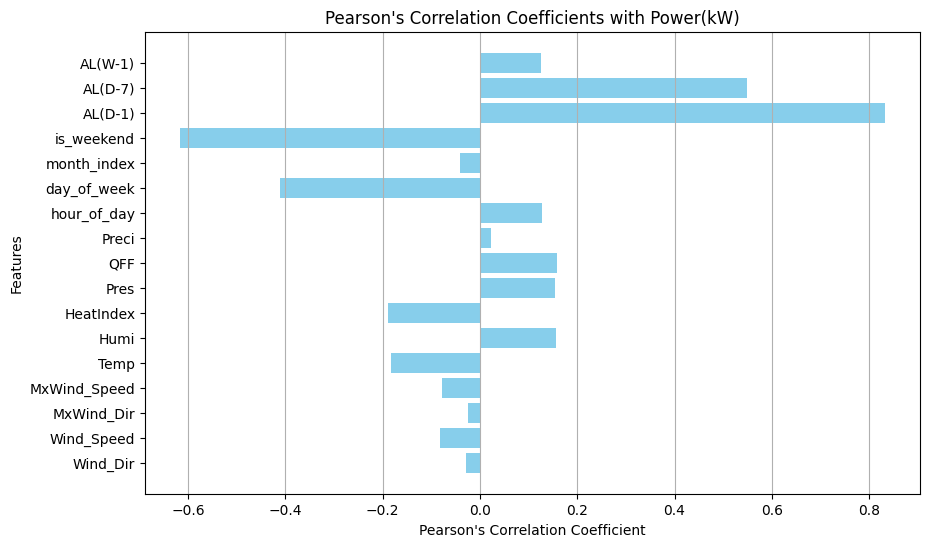

In [ ]:
from scipy.stats import pearsonr
correlation_coefficients = {}
for col_name in df.columns[1:-3]:  # Exclude the 'y' column
    correlation_coefficient, _ = pearsonr(df['Power(kW)'], df[col_name])
    correlation_coefficients[col_name] = correlation_coefficient

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

for col_name, correlation_coefficient in correlation_coefficients.items():
  if col_name != 'Power(kW)':
    plt.barh(col_name, correlation_coefficient, color='skyblue')

# Adding labels and title
plt.xlabel("Pearson's Correlation Coefficient")
plt.ylabel('Features')
plt.title('Pearson\'s Correlation Coefficients with Power(kW)')
plt.grid(axis='x')
plt.show()

In [ ]:
columns_to_drop = [ 'Preci','AL(M-12)','AL(D-365)']
df = df.drop(columns=columns_to_drop)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17656 entries, 0 to 17999
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datetime      17656 non-null  datetime64[ns]
 1   Power(kW)     17656 non-null  float64       
 2   Wind_Dir      17656 non-null  float64       
 3   Wind_Speed    17656 non-null  float64       
 4   MxWind_Dir    17656 non-null  float64       
 5   MxWind_Speed  17656 non-null  float64       
 6   Temp          17656 non-null  float64       
 7   Humi          17656 non-null  float64       
 8   HeatIndex     17656 non-null  float64       
 9   Pres          17656 non-null  float64       
 10  QFF           17656 non-null  float64       
 11  hour_of_day   17656 non-null  int64         
 12  day_of_week   17656 non-null  int64         
 13  month_index   17656 non-null  int64         
 14  is_weekend    17656 non-null  int64         
 15  AL(D-1)       17656 non-null  float6

In [ ]:
#Model 1
#Setting parameters as provided by Chatgpt
#MSE = 0.00209773344938531
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming you have a DataFrame 'df' with timestamp and input columns
# Adjust these based on your actual data and requirements

input_columns = df.columns[1:]
n_steps = 10  # Adjust the number of time steps based on your requirements

def prepare_data(df, input_columns, n_steps):
    sequences = []
    for i in range(len(df) - n_steps):
        seq = df[input_columns].values[i:i + n_steps]
        sequences.append(seq)
    return np.array(sequences)

def build_lstm_autoencoder(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(input_shape)))
    model.add(RepeatVector(input_shape[0]))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(input_shape[1])))
    model.compile(optimizer='adam', loss='mse')
    return model

try:
    X_train = prepare_data(df, input_columns, n_steps)

    # Normalize the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, len(input_columns))).reshape(X_train.shape)

    # Build Model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_autoencoder(input_shape)

    split_idx = int(0.8 * len(X_train_scaled))
    X_train_train = X_train_scaled[:split_idx]
    X_train_test = X_train_scaled[split_idx:]

    # Train Model
    model.fit(X_train_train, X_train_train, epochs=50, batch_size=32, validation_data=(X_train_test, X_train_test))

    # Make Predictions on the Testing Data
    X_test_pred = model.predict(X_train_test)

    # Calculate Reconstruction Error (MSE) on Testing Data
    mse_test = np.mean(np.square(X_train_test - X_test_pred), axis=(1, 2))

    # Set the threshold as a percentile
    threshold = np.percentile(mse_test, 95)

    # Detect Anomalies
    anomalies_test = df[split_idx + n_steps:][mse_test > threshold]

    # Visualize Reconstruction Errors
    plt.figure(figsize=(10, 6))
    plt.hist(mse_test, bins=50, density=True, alpha=0.7, color='blue', label='Normal (Testing)')
    plt.hist(mse_test[mse_test > threshold], bins=50, density=True, alpha=0.7, color='red', label='Anomalies (Testing)')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors (Testing)')
    plt.legend()
    plt.show()

except Exception as e:
    # Print the exception to understand the error
    print("An error occurred:", e)

mean_mse_test = np.mean(mse_test)
print("Overall MSE", mean_mse_test)


Epoch 1/200
111/111 [==============================] - 6s 27ms/step - loss: 0.0540 - val_loss: 0.0150
Epoch 2/200
111/111 [==============================] - 3s 24ms/step - loss: 0.0042 - val_loss: 0.0081
Epoch 3/200
111/111 [==============================] - 3s 26ms/step - loss: 0.0028 - val_loss: 0.0073
Epoch 4/200
111/111 [==============================] - 3s 24ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 5/200
111/111 [==============================] - 3s 24ms/step - loss: 0.0024 - val_loss: 0.0067
Epoch 6/200
111/111 [==============================] - 3s 24ms/step - loss: 0.0023 - val_loss: 0.0065
Epoch 7/200
111/111 [==============================] - 3s 25ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 8/200
111/111 [==============================] - 3s 24ms/step - loss: 0.0022 - val_loss: 0.0063
Epoch 9/200
111/111 [==============================] - 3s 23ms/step - loss: 0.0022 - val_loss: 0.0059
Epoch 10/200
111/111 [==============================] - 3s 24ms/step - loss: 0.002

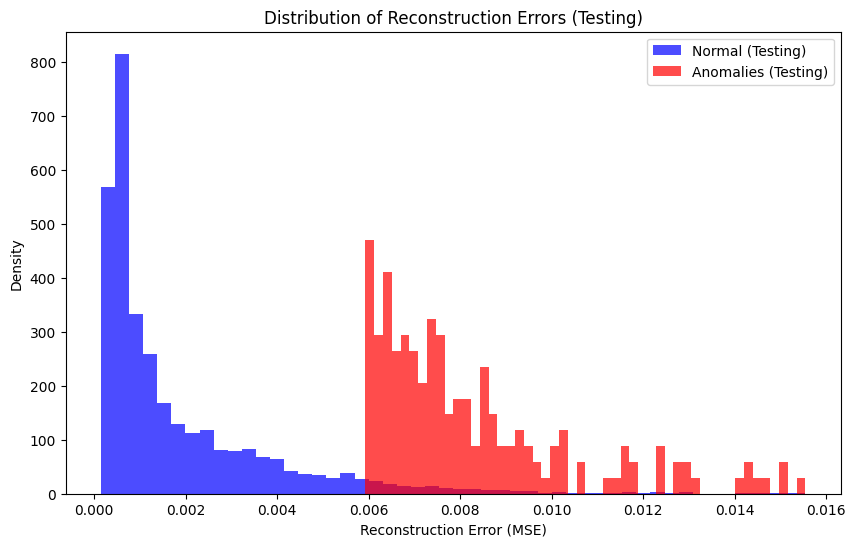

Overall MSE 0.0018306800808099238


In [ ]:
#Model 2
#Setting parameters as reference paper 4
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Assuming you have a DataFrame 'df' with timestamp and input columns
# Adjust these based on your actual data and requirements

input_columns = df.columns[1:]
n_steps = 10  # Adjust the number of time steps based on your requirements

def prepare_data(df, input_columns, n_steps):
    sequences = []
    for i in range(len(df) - n_steps):
        seq = df[input_columns].values[i:i + n_steps]
        sequences.append(seq)
    return np.array(sequences)

def build_lstm_autoencoder(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(input_shape)))
    model.add(RepeatVector(input_shape[0]))
    model.add(LSTM(100, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(input_shape[1])))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

try:
    # Prepare Data
    X_train = prepare_data(df, input_columns, n_steps)

    # Normalize the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, len(input_columns))).reshape(X_train.shape)

    # Build Model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_autoencoder(input_shape)

    split_idx = int(0.8 * len(X_train_scaled))
    X_train_train = X_train_scaled[:split_idx]
    X_train_test = X_train_scaled[split_idx:]

    # Train Model
    model.fit(X_train_train, X_train_train, epochs=200, batch_size=128, validation_data=(X_train_test, X_train_test))

    # Make Predictions on the Training Data
    X_test_pred = model.predict(X_train_test)

    # Calculate Reconstruction Error (MSE)
    mse_test = np.mean(np.square(X_train_test - X_test_pred), axis=(1, 2))

    # Set the threshold as a percentile
    threshold = np.percentile(mse_test, 95)

    # Detect Anomalies
    anomalies_test = df[split_idx + n_steps:][mse_test > threshold]

    plt.figure(figsize=(10, 6))
    plt.hist(mse_test, bins=50, density=True, alpha=0.7, color='blue', label='Normal (Testing)')
    plt.hist(mse_test[mse_test > threshold], bins=50, density=True, alpha=0.7, color='red', label='Anomalies (Testing)')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors (Testing)')
    plt.legend()
    plt.show()

except Exception as e:
    # Print the exception to understand the error
    print("An error occurred:", e)

mean_mse_test = np.mean(mse_test)
print("Overall MSE", mean_mse_test)


Epoch 1/50
56/56 [==============================] - 23s 164ms/step - loss: 0.2350 - val_loss: 0.1395
Epoch 2/50
56/56 [==============================] - 8s 144ms/step - loss: 0.0890 - val_loss: 0.0805
Epoch 3/50
56/56 [==============================] - 8s 140ms/step - loss: 0.0567 - val_loss: 0.0595
Epoch 4/50
56/56 [==============================] - 8s 143ms/step - loss: 0.0481 - val_loss: 0.0598
Epoch 5/50
56/56 [==============================] - 8s 140ms/step - loss: 0.0460 - val_loss: 0.0577
Epoch 6/50
56/56 [==============================] - 8s 140ms/step - loss: 0.0421 - val_loss: 0.0528
Epoch 7/50
56/56 [==============================] - 8s 139ms/step - loss: 0.0345 - val_loss: 0.0430
Epoch 8/50
56/56 [==============================] - 8s 143ms/step - loss: 0.0306 - val_loss: 0.0432
Epoch 9/50
56/56 [==============================] - 8s 140ms/step - loss: 0.0280 - val_loss: 0.0396
Epoch 10/50
56/56 [==============================] - 8s 139ms/step - loss: 0.0257 - val_loss: 0.036

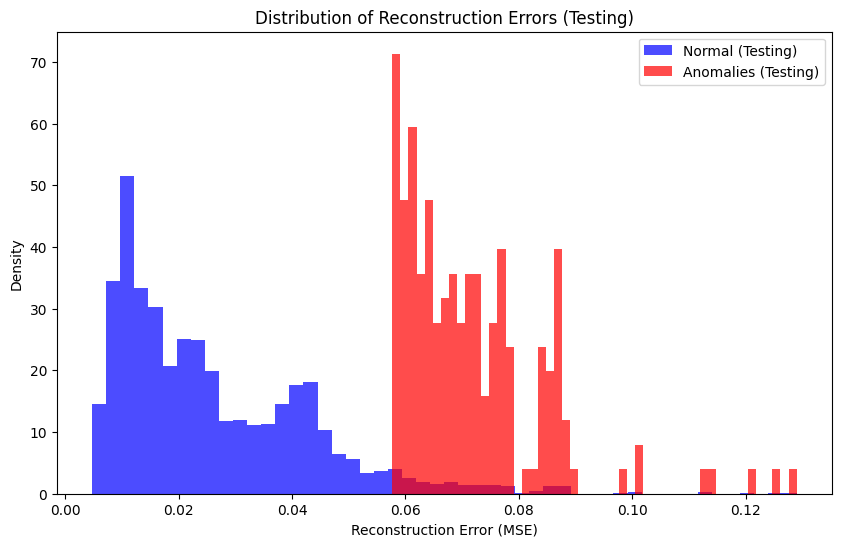

Overall MSE 0.025854917790202967


In [ ]:
#Model 3
#LSTM-Autoencoder with setting from Ref.Paper 3
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed,Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming you have a DataFrame 'df' with timestamp and input columns
# Adjust these based on your actual data and requirements

input_columns = df.columns[1:]
n_steps = 10  # Adjust the number of time steps based on your requirements

def prepare_data(df, input_columns, n_steps):
    sequences = []
    for i in range(len(df) - n_steps):
        seq = df[input_columns].values[i:i + n_steps]
        sequences.append(seq)
    return np.array(sequences)

def build_lstm_autoencoder(input_shape):
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(input_shape), return_sequences=True))
    model.add(Dropout(0.2))  # Adding dropout for regularization
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu'))
    model.add(RepeatVector(input_shape[0]))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(input_shape[1])))
    model.compile(optimizer='adam', loss='mse')
    return model

try:
    X_train = prepare_data(df, input_columns, n_steps)

    # Normalize the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, len(input_columns))).reshape(X_train.shape)

    # Build Model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_autoencoder(input_shape)


    split_idx = int(0.8 * len(X_train_scaled))
    X_train_train = X_train_scaled[:split_idx]
    X_train_test = X_train_scaled[split_idx:]

    # Train Model
    model.fit(X_train_train, X_train_train, epochs=50, batch_size=256, validation_data=(X_train_test, X_train_test))

    # Make Predictions on the Training Data
    X_test_pred = model.predict(X_train_test)

    # Calculate Reconstruction Error (MSE)
    mse_test = np.mean(np.square(X_train_test - X_test_pred), axis=(1, 2))

    # Set the threshold as a percentile
    threshold = np.percentile(mse_test, 95)

    # Detect Anomalies
    anomalies_test = df[split_idx + n_steps:][mse_test > threshold]

    plt.figure(figsize=(10, 6))
    plt.hist(mse_test, bins=50, density=True, alpha=0.7, color='blue', label='Normal (Testing)')
    plt.hist(mse_test[mse_test > threshold], bins=50, density=True, alpha=0.7, color='red', label='Anomalies (Testing)')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors (Testing)')
    plt.legend()
    plt.show()

except Exception as e:
    # Print the exception to understand the error
    print("An error occurred:", e)

mean_mse_test = np.mean(mse_test)
print("Overall MSE", mean_mse_test)


Epoch 1/50
497/497 [==============================] - 15s 21ms/step - loss: 0.0091 - val_loss: 0.0011
Epoch 2/50
497/497 [==============================] - 10s 20ms/step - loss: 4.9820e-04 - val_loss: 5.0610e-04
Epoch 3/50
497/497 [==============================] - 10s 20ms/step - loss: 2.5257e-04 - val_loss: 3.2442e-04
Epoch 4/50
497/497 [==============================] - 10s 20ms/step - loss: 1.6713e-04 - val_loss: 2.1861e-04
Epoch 5/50
497/497 [==============================] - 10s 20ms/step - loss: 1.2605e-04 - val_loss: 1.9363e-04
Epoch 6/50
497/497 [==============================] - 10s 20ms/step - loss: 1.0208e-04 - val_loss: 1.4928e-04
Epoch 7/50
497/497 [==============================] - 10s 20ms/step - loss: 8.8882e-05 - val_loss: 1.5169e-04
Epoch 8/50
497/497 [==============================] - 10s 21ms/step - loss: 7.8443e-05 - val_loss: 1.2885e-04
Epoch 9/50
497/497 [==============================] - 10s 20ms/step - loss: 7.0764e-05 - val_loss: 1.2511e-04
Epoch 10/50
497/49

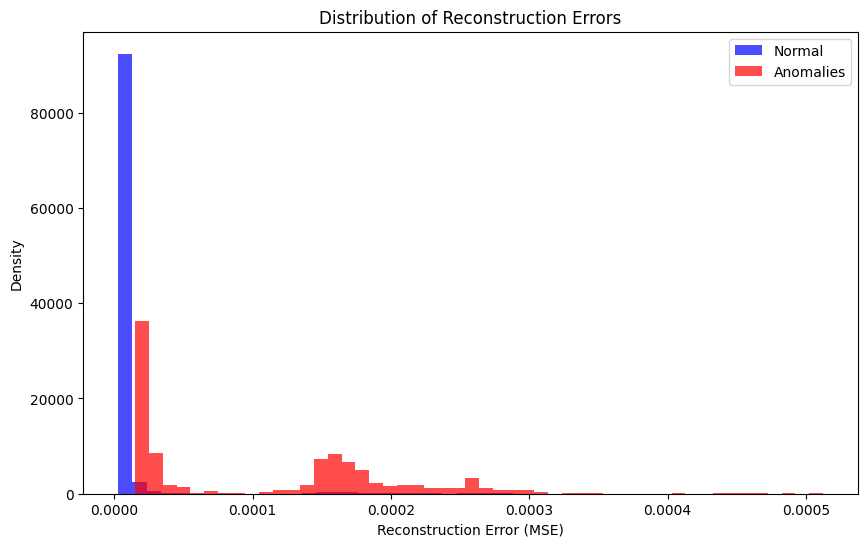

Overall MSE: 1.1218495623116078e-05


In [ ]:
#model 4 results on train data
from tensorflow.keras.layers import Bidirectional
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Assuming you have a DataFrame 'df' with timestamp and input columns
# Adjust these based on your actual data and requirements

input_columns = df.columns[1:]
n_steps = 10  # Adjust the number of time steps based on your requirements

def prepare_data(df, input_columns, n_steps):
    sequences = []
    for i in range(len(df) - n_steps):
        seq = df[input_columns].values[i:i + n_steps]
        sequences.append(seq)
    return np.array(sequences)

def build_bidirectional_lstm_autoencoder(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(input_shape)))
    model.add(TimeDistributed(Dense(input_shape[1])))
    model.compile(optimizer='adam', loss='mse')
    return model

try:
    X_train = prepare_data(df, input_columns, n_steps)

    # Normalize the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, len(input_columns))).reshape(X_train.shape)

    # Build Model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_bidirectional_lstm_autoencoder(input_shape)

    # Train Model
    model.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, validation_split=0.1)

    # Make Predictions on the Training Data
    X_train_pred = model.predict(X_train_scaled)

    # Calculate Reconstruction Error (MSE)
    mse = np.mean(np.square(X_train_scaled - X_train_pred), axis=(1, 2))

    # Set the threshold as a percentile
    threshold = np.percentile(mse, 95)

    # Detect Anomalies
    anomalies = df[n_steps:][mse > threshold]

    # Visualize Reconstruction Errors
    plt.figure(figsize=(10, 6))
    plt.hist(mse, bins=50, density=True, alpha=0.7, color='blue', label='Normal')
    plt.hist(mse[mse > threshold], bins=50, density=True, alpha=0.7, color='red', label='Anomalies')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors')
    plt.legend()
    plt.show()

except Exception as e:
    # Print the exception to understand the error
    print("An error occurred:", e)


mse = mean_squared_error(X_train_scaled.flatten(), X_train_pred.flatten())

print("Overall MSE:", mse)


Epoch 1/50
56/56 [==============================] - 4s 27ms/step - loss: 0.0784 - val_loss: 0.0261
Epoch 2/50
56/56 [==============================] - 1s 23ms/step - loss: 0.0085 - val_loss: 0.0113
Epoch 3/50
56/56 [==============================] - 1s 23ms/step - loss: 0.0043 - val_loss: 0.0067
Epoch 4/50
56/56 [==============================] - 1s 21ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 5/50
56/56 [==============================] - 1s 22ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 6/50
56/56 [==============================] - 1s 21ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 7/50
56/56 [==============================] - 1s 22ms/step - loss: 9.6701e-04 - val_loss: 0.0020
Epoch 8/50
56/56 [==============================] - 1s 22ms/step - loss: 7.9260e-04 - val_loss: 0.0016
Epoch 9/50
56/56 [==============================] - 1s 22ms/step - loss: 6.7502e-04 - val_loss: 0.0014
Epoch 10/50
56/56 [==============================] - 1s 23ms/step - loss: 5.9991e-04 - val_loss: 

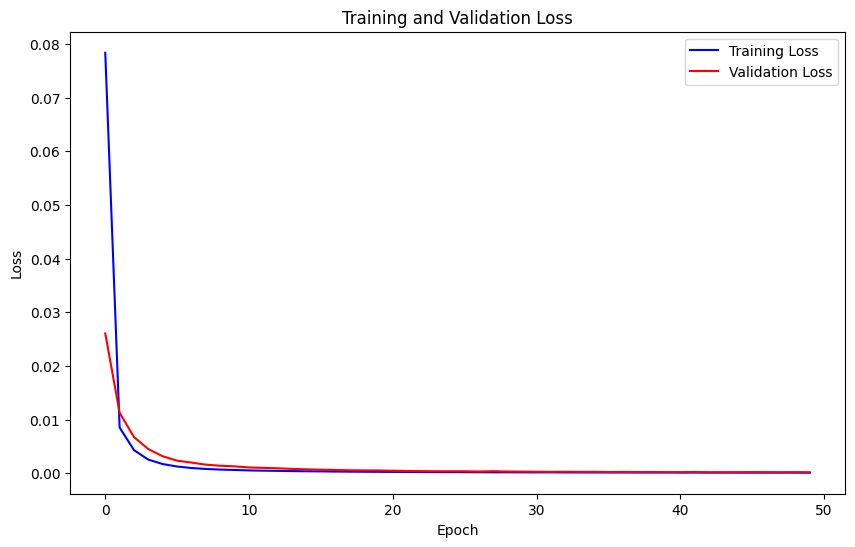

111/111 [==============================] - 1s 4ms/step


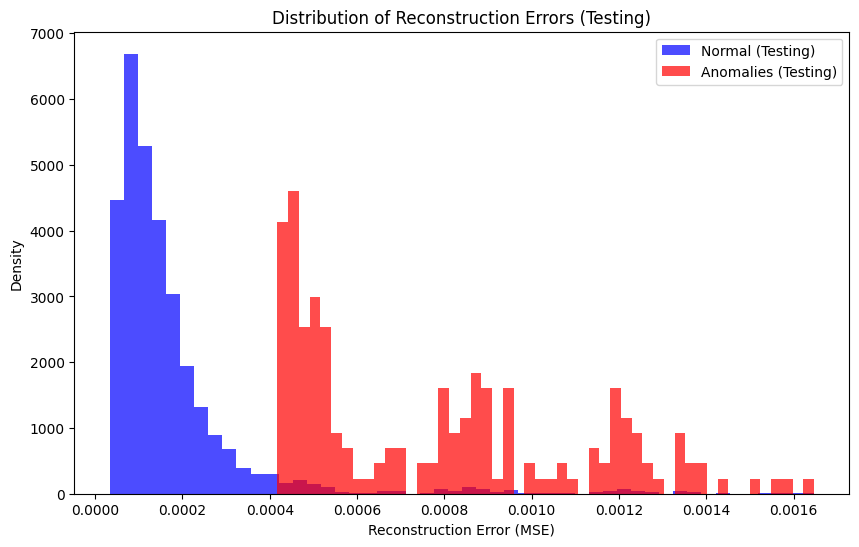

Overall MSE 0.00016977022439255575


In [ ]:
#model 4 results of test data
from tensorflow.keras.layers import Bidirectional
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Assuming you have a DataFrame 'df' with timestamp and input columns
# Adjust these based on your actual data and requirements

input_columns = df.columns[1:]
n_steps = 10  # Adjust the number of time steps based on your requirements

def prepare_data(df, input_columns, n_steps):
    sequences = []
    for i in range(len(df) - n_steps):
        seq = df[input_columns].values[i:i + n_steps]
        sequences.append(seq)
    return np.array(sequences)

def build_bidirectional_lstm_autoencoder(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(input_shape)))
    model.add(TimeDistributed(Dense(input_shape[1])))
    model.compile(optimizer='adam', loss='mse')
    return model

try:
    X_train = prepare_data(df, input_columns, n_steps)

    # Normalize the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, len(input_columns))).reshape(X_train.shape)

    # Build Model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_bidirectional_lstm_autoencoder(input_shape)

    split_idx = int(0.8 * len(X_train_scaled))
    X_train_train = X_train_scaled[:split_idx]
    X_train_test = X_train_scaled[split_idx:]

    # Train Model
    history = model.fit(X_train_train, X_train_train, epochs=50, batch_size=256, validation_data=(X_train_test, X_train_test))

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss, label='Training Loss', color='blue')
    plt.plot(validation_loss, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()



    # Make Predictions on the Training Data
    X_test_pred = model.predict(X_train_test)


    # Calculate Reconstruction Error (MSE)
    mse_test = np.mean(np.square(X_train_test - X_test_pred), axis=(1, 2))

    # Set the threshold as a percentile
    threshold = np.percentile(mse_test, 95)

    # Detect Anomalies
    anomalies_test = df[split_idx + n_steps:][mse_test > threshold]

    # Visualize Reconstruction Errors
    anomalies_test = df[split_idx + n_steps:][mse_test > threshold]

    plt.figure(figsize=(10, 6))
    plt.hist(mse_test, bins=50, density=True, alpha=0.7, color='blue', label='Normal (Testing)')
    plt.hist(mse_test[mse_test > threshold], bins=50, density=True, alpha=0.7, color='red', label='Anomalies (Testing)')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors (Testing)')
    plt.legend()
    plt.show()



except Exception as e:
    # Print the exception to understand the error
    print("An error occurred:", e)

mean_mse_test = np.mean(mse_test)
print("Overall MSE", mean_mse_test)

Epoch 1/50
111/111 [==============================] - 20s 101ms/step - loss: 0.2493 - val_loss: 0.0735
Epoch 2/50
111/111 [==============================] - 10s 90ms/step - loss: 0.0324 - val_loss: 0.0336
Epoch 3/50
111/111 [==============================] - 10s 91ms/step - loss: 0.0129 - val_loss: 0.0210
Epoch 4/50
111/111 [==============================] - 10s 93ms/step - loss: 0.0079 - val_loss: 0.0153
Epoch 5/50
111/111 [==============================] - 10s 94ms/step - loss: 0.0058 - val_loss: 0.0127
Epoch 6/50
111/111 [==============================] - 10s 94ms/step - loss: 0.0048 - val_loss: 0.0109
Epoch 7/50
111/111 [==============================] - 10s 94ms/step - loss: 0.0041 - val_loss: 0.0104
Epoch 8/50
111/111 [==============================] - 11s 95ms/step - loss: 0.0036 - val_loss: 0.0096
Epoch 9/50
111/111 [==============================] - 10s 93ms/step - loss: 0.0033 - val_loss: 0.0093
Epoch 10/50
111/111 [==============================] - 10s 93ms/step - loss: 0.00

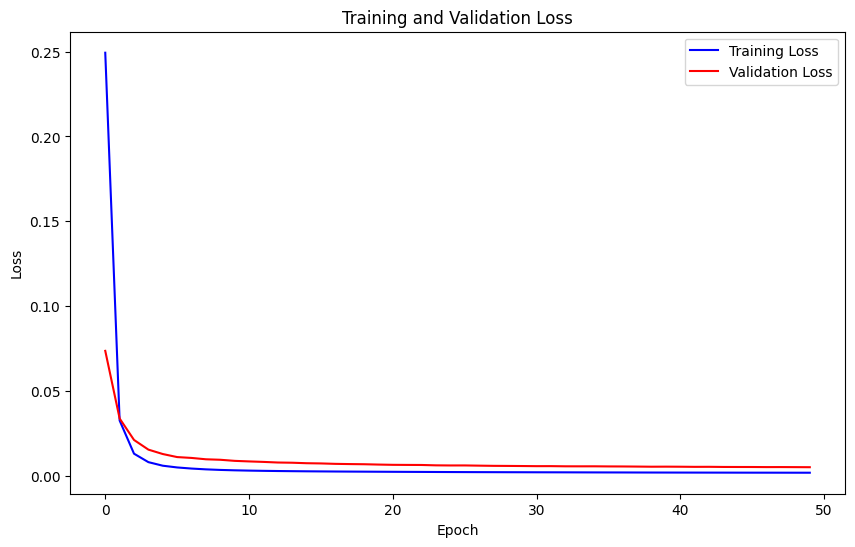

111/111 [==============================] - 3s 15ms/step


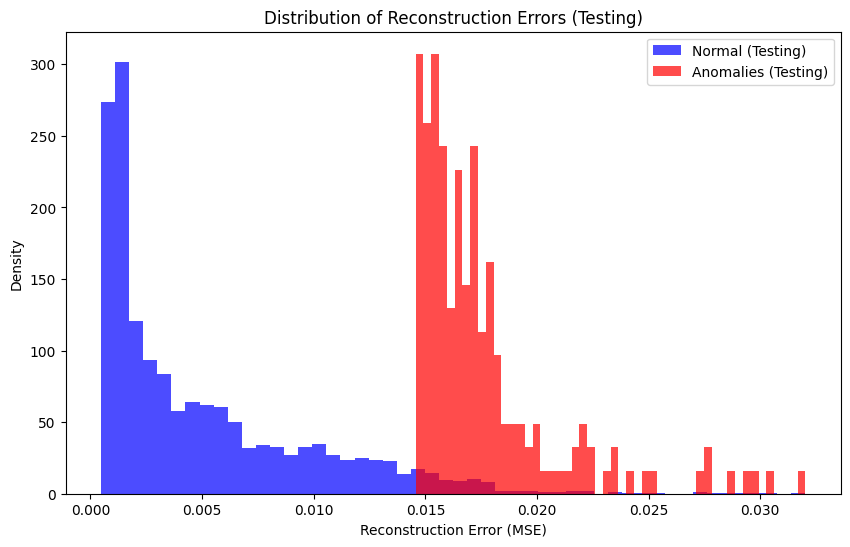

Overall MSE 0.004916435060345592


In [ ]:
#model 5 results of test data
from tensorflow.keras.layers import Bidirectional
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Assuming you have a DataFrame 'df' with timestamp and input columns
# Adjust these based on your actual data and requirements

input_columns = df.columns[1:]
n_steps = 10  # Adjust the number of time steps based on your requirements

def prepare_data(df, input_columns, n_steps):
    sequences = []
    for i in range(len(df) - n_steps):
        seq = df[input_columns].values[i:i + n_steps]
        sequences.append(seq)
    return np.array(sequences)

def build_bidirectional_lstm_autoencoder(input_shape):
    model = Sequential()
    # Encoder layers
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(32, activation='relu')))
    # Decoder layers
    model.add(RepeatVector(input_shape[0]))
    model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
    model.add(TimeDistributed(Dense(input_shape[1])))
    # Compile model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

try:
    X_train = prepare_data(df, input_columns, n_steps)

    # Normalize the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, len(input_columns))).reshape(X_train.shape)

    # Build Model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_bidirectional_lstm_autoencoder(input_shape)

    split_idx = int(0.8 * len(X_train_scaled))
    X_train_train = X_train_scaled[:split_idx]
    X_train_test = X_train_scaled[split_idx:]

    # Train Model
    history = model.fit(X_train_train, X_train_train, epochs=50, batch_size=128, validation_data=(X_train_test, X_train_test))

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss, label='Training Loss', color='blue')
    plt.plot(validation_loss, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()



    # Make Predictions on the Training Data
    X_test_pred = model.predict(X_train_test)


    # Calculate Reconstruction Error (MSE)
    mse_test = np.mean(np.square(X_train_test - X_test_pred), axis=(1, 2))

    # Set the threshold as a percentile
    threshold = np.percentile(mse_test, 95)

    # Detect Anomalies
    anomalies_test = df[split_idx + n_steps:][mse_test > threshold]

    # Visualize Reconstruction Errors
    anomalies_test = df[split_idx + n_steps:][mse_test > threshold]

    plt.figure(figsize=(10, 6))
    plt.hist(mse_test, bins=50, density=True, alpha=0.7, color='blue', label='Normal (Testing)')
    plt.hist(mse_test[mse_test > threshold], bins=50, density=True, alpha=0.7, color='red', label='Anomalies (Testing)')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Density')
    plt.title('Distribution of Reconstruction Errors (Testing)')
    plt.legend()
    plt.show()



except Exception as e:
    # Print the exception to understand the error
    print("An error occurred:", e)

mean_mse_test = np.mean(mse_test)
print("Overall MSE", mean_mse_test)

In [ ]:
X_combined = np.concatenate([X_train_train, X_train_test])

X_pred = model.predict(X_combined)

    # Calculate Reconstruction Error (MSE)
mse_combined = np.mean(np.square(X_combined - X_pred), axis=(1, 2))

    # Set the threshold as a percentile
threshold_combined = np.percentile(mse_combined, 95)

    # Detect Anomalies
anomalies_combined = df[n_steps:][mse_combined > threshold_combined]

    # Plot anomaly detection results using Plotly Go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Datetime'], y=df['Power(kW)'], mode='lines', name='Power(kW)', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=anomalies_combined['Datetime'], y=anomalies_combined['Power(kW)'], mode='markers', name='Detected Anomalies', marker=dict(color='red', size=10)))
fig.update_layout(xaxis_title='Timestamp', yaxis_title='Power(kW)', title='Anomaly Detection by Bi-LSTM Autoencoder',title_x=0.5)
fig.show()


mean_mse_combined = np.mean(mse_combined)
print("Overall MSE", mean_mse_combined)

NameError: name 'X_train_train' is not defined

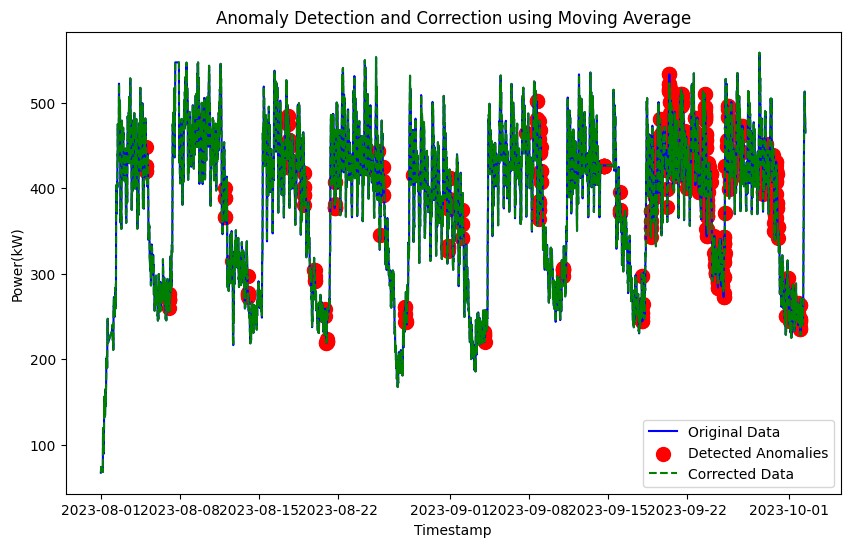

In [ ]:
# Calculate Moving Average of the Entire Dataset
window_size = 10  # Adjust the window size based on your requirements
moving_average = df['Power(kW)'].rolling(window=window_size, min_periods=1, center=True).mean()

# Replace Anomalies with Moving Average Values
df_corrected = df.copy()  # Create a copy to store corrected data
df_corrected.loc[anomalies_combined.index, 'Power(kW)'] = moving_average.loc[anomalies_combined.index]

# Visualize the Correction
plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['Power(kW)'], label='Original Data', color='blue')
plt.scatter(anomalies_combined['Datetime'], anomalies_combined['Power(kW)'], color='red', label='Detected Anomalies', s=100)
plt.plot(df_corrected['Datetime'], df_corrected['Power(kW)'], label='Corrected Data', color='green', linestyle='dashed')
plt.xlabel('Timestamp')
plt.ylabel('Power(kW)')
plt.title('Anomaly Detection and Correction using Moving Average')
plt.legend()
plt.show()


In [ ]:
# Calculate Total Billing Amount Before Correction
total_billing_before_correction = df['Power(kW)'].sum()

# Calculate Total Billing Amount After Correction
total_billing_after_correction = df_corrected['Power(kW)'].sum()

# Print the Results
print("Total Billing Amount Before Correction:", total_billing_before_correction)
print("Total Billing Amount After Correction:", total_billing_after_correction)
print(total_billing_before_correction-total_billing_after_correction)

Total Billing Amount Before Correction: 6771819.820539954
Total Billing Amount After Correction: 6771980.560415898
-160.7398759443313


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_21 (Bidirect  (None, 10, 128)           42496     
 ional)                                                          
                                                                 
 bidirectional_22 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 repeat_vector_5 (RepeatVec  (None, 10, 64)            0         
 tor)                                                            
                                                                 
 bidirectional_23 (Bidirect  (None, 10, 64)            24832     
 ional)                                                          
                                                                 
 bidirectional_24 (Bidirect  (None, 10, 128)          

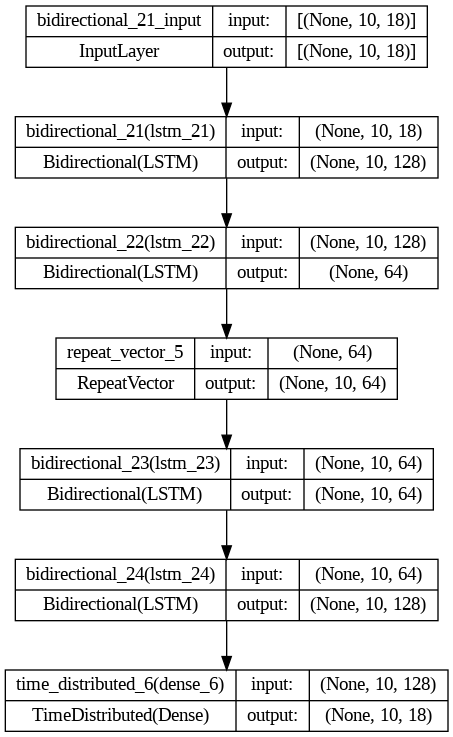

In [ ]:
from tensorflow.keras.utils import plot_model
model.summary()
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [ ]:
anomalies_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 883 entries, 1154 to 17865
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datetime      883 non-null    datetime64[ns]
 1   Power(kW)     883 non-null    float64       
 2   Wind_Dir      883 non-null    float64       
 3   Wind_Speed    883 non-null    float64       
 4   MxWind_Dir    883 non-null    float64       
 5   MxWind_Speed  883 non-null    float64       
 6   Temp          883 non-null    float64       
 7   Humi          883 non-null    float64       
 8   HeatIndex     883 non-null    float64       
 9   Pres          883 non-null    float64       
 10  QFF           883 non-null    float64       
 11  hour_of_day   883 non-null    int64         
 12  day_of_week   883 non-null    int64         
 13  month_index   883 non-null    int64         
 14  is_weekend    883 non-null    int64         
 15  AL(D-1)       883 non-null    float